In [1]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


######################################################
################### TENSORBOARD ######################
######################################################

writer = SummaryWriter('runs/VN_Dishes')

######################################################

cuda


In [2]:
transform = transforms.Compose([
        transforms.RandomRotation(10),      
        transforms.RandomHorizontalFlip(),  
        transforms.Resize(244),             
        transforms.CenterCrop(244),         
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform = None):
        self.data = datasets.ImageFolder(root, transform = transform)
        self.classes = self.data.classes
        self.num_classes = len(self.classes)
    def __getitem__(self, index):
        img, label = self.data[index]
        one_hot_label = F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()
        return img, one_hot_label   
    
    def __len__(self):
            return len(self.data)
        
x_train = FoodDataset( root=("/kaggle/input/vn-food/Food/Train"), transform = transform)
x_val = FoodDataset(root = ('/kaggle/input/vn-food/Food/Val'), transform = transform)

In [3]:
class_name = x_train.classes
print("Tổng class: ",len(class_name))
print("Tên các loại: ",class_name)

batch = 128
epochs = 80
learning_rate = 1e-3
weight_decay = 1e-4

train_loader = DataLoader(x_train, batch_size = batch, shuffle = True)
val_loader = DataLoader(x_val, batch_size = batch, shuffle = True)


examples = iter(val_loader)
example_data, example_targets = next(examples)

######################################################
################### TENSORBOARD ######################
######################################################

img_grid = torchvision.utils.make_grid(example_data)
writer.add_image("Foods",img_grid)
writer.close()

######################################################

Tổng class:  10
Tên các loại:  ['Banh bot loc', 'Banh chung', 'Banh khot', 'Banh mi', 'Banh trang nuong', 'Bun bo Hue', 'Bun thit nuong', 'Chao long', 'Com tam', 'Xoi xeo']


In [4]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
#     self.relu = F.leaky_relu()
    self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv1 = nn.Conv2d(3,32,3,stride = 1, padding = 2)
    self.conv2 = nn.Conv2d(32,64,3,stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(64,128,3,stride = 1, padding = 1)
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    self.dropout = nn.Dropout(p = 0.5)
    self.fc1 = nn.Linear(7*7*128, 1000)
    self.fc2 = nn.Linear(1000,128)
    self.fc3 = nn.Linear(128, 10)
    
  def forward(self, x):
    x = self.maxpool(F.leaky_relu(self.conv1(x)))
    x = self.maxpool(F.leaky_relu(self.conv2(x)))
    x = self.maxpool(F.leaky_relu(self.conv3(x)))
    x = self.avgpool(x)
    x = x.view(-1, 7*7*128)
    x = self.dropout(F.leaky_relu(self.fc1(x)))
    x = self.dropout(F.leaky_relu(self.fc2(x)))
    x = self.fc3(x)

    return x

model = CNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

######################################################
################### TENSORBOARD ######################
######################################################

writer.add_graph(model, example_data.to(device))
writer.close()

######################################################

In [5]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    864     |
|  conv1.bias  |     32     |
| conv2.weight |   18432    |
|  conv2.bias  |     64     |
| conv3.weight |   73728    |
|  conv3.bias  |    128     |
|  fc1.weight  |  6272000   |
|   fc1.bias   |    1000    |
|  fc2.weight  |   128000   |
|   fc2.bias   |    128     |
|  fc3.weight  |    1280    |
|   fc3.bias   |     10     |
+--------------+------------+
Total Trainable Params: 6495666


6495666

In [6]:
n_total_steps = len(train_loader)

run_loss = 0.0
run_acc = 0.0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.reshape(-1,3,244,244).to(device)
        labels = labels.to(device)
        _, labels = torch.max(labels.data, 1)

        outputs = model(images)

        loss = criterion(outputs,labels)
        
        run_loss +=loss.item() #for tensorboard
        _,pred = torch.max(outputs.data, 1)
        run_acc += (pred==labels).sum().item()#for tensorboard
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 3 == 0:
            
            ############################## Check validation_data ###################################
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(10)]
                n_class_samples = [0 for i in range(10)]
                
                for images_val, labels_val in val_loader:
                    images_val = images_val.reshape(-1,3,244,244).to(device)
                    labels_val = labels_val.to(device)
                    _, labels_val = torch.max(labels_val.data, 1)
                    
                    output_val = model(images_val)
                    _, predict_val = torch.max(output_val.data, 1)
                    n_samples += labels_val.size(0)
                    n_correct += (predict_val == labels_val).sum().item()
                    loss_val = F.mse_loss(labels_val.float(),predict_val.float())
                    for i in range(26):
                        label_val = labels_val[i]
                        pred_val = predict_val[i]
                        if label_val == pred_val:
                            n_class_correct[label_val] += 1
                            
                        n_class_samples[label_val] += 1
                        
                acc_val = n_correct/(n_samples)
                acc_val_total = run_acc/((3-1)*128+pred.size(0))

                
                print(f'Epoch[{epoch+1}/{epochs}]:  Loss_Train: {(run_loss/3):.2f}, Acc_Train: {acc_val_total:.2f} , Loss_Val: {loss_val:.2f} , Acc_Val: {acc_val:.2f}')
            
            
            ################################################################################################################
            #################################################### TENSORBOARD ###############################################
            ################################################################################################################           
            writer.add_scalars("Loss and Loss_valid", {'Loss': run_loss/3, 'Loss_valid':loss_val}, epoch*n_total_steps+i)
            writer.add_scalars('Accuracy and Accuracy_valid', {'Accuracy':100*run_acc/((3-1)*128+pred.size(0)),'Accuracy_valid':acc_val}, epoch*n_total_steps+i)
            
            run_loss = 0.0
            run_acc = 0.0
            ################################################################################################################           

print('Finished Training')

100%|██████████| 3/3 [00:13<00:00,  4.60s/it]


Epoch[1/80]:  Loss_Train: 2.32, Acc_Train: 0.05 , Loss_Val: 18.87 , Acc_Val: 0.08


100%|██████████| 3/3 [00:11<00:00,  3.98s/it]


Epoch[2/80]:  Loss_Train: 2.29, Acc_Train: 0.12 , Loss_Val: 13.53 , Acc_Val: 0.12


100%|██████████| 3/3 [00:11<00:00,  3.82s/it]


Epoch[3/80]:  Loss_Train: 2.25, Acc_Train: 0.14 , Loss_Val: 15.30 , Acc_Val: 0.12


100%|██████████| 3/3 [00:11<00:00,  3.83s/it]


Epoch[4/80]:  Loss_Train: 2.19, Acc_Train: 0.15 , Loss_Val: 13.82 , Acc_Val: 0.18


100%|██████████| 3/3 [00:11<00:00,  3.97s/it]


Epoch[5/80]:  Loss_Train: 2.14, Acc_Train: 0.20 , Loss_Val: 11.78 , Acc_Val: 0.19


100%|██████████| 3/3 [00:11<00:00,  3.76s/it]


Epoch[6/80]:  Loss_Train: 2.12, Acc_Train: 0.20 , Loss_Val: 14.19 , Acc_Val: 0.27


100%|██████████| 3/3 [00:11<00:00,  3.80s/it]


Epoch[7/80]:  Loss_Train: 2.01, Acc_Train: 0.28 , Loss_Val: 11.77 , Acc_Val: 0.28


100%|██████████| 3/3 [00:11<00:00,  3.92s/it]


Epoch[8/80]:  Loss_Train: 1.93, Acc_Train: 0.28 , Loss_Val: 10.67 , Acc_Val: 0.35


100%|██████████| 3/3 [00:11<00:00,  3.77s/it]


Epoch[9/80]:  Loss_Train: 1.91, Acc_Train: 0.29 , Loss_Val: 16.17 , Acc_Val: 0.31


100%|██████████| 3/3 [00:11<00:00,  3.95s/it]


Epoch[10/80]:  Loss_Train: 1.84, Acc_Train: 0.30 , Loss_Val: 11.91 , Acc_Val: 0.30


100%|██████████| 3/3 [00:11<00:00,  3.86s/it]


Epoch[11/80]:  Loss_Train: 1.83, Acc_Train: 0.34 , Loss_Val: 11.93 , Acc_Val: 0.35


100%|██████████| 3/3 [00:11<00:00,  3.82s/it]


Epoch[12/80]:  Loss_Train: 1.73, Acc_Train: 0.39 , Loss_Val: 11.56 , Acc_Val: 0.36


100%|██████████| 3/3 [00:11<00:00,  3.97s/it]


Epoch[13/80]:  Loss_Train: 1.66, Acc_Train: 0.42 , Loss_Val: 9.62 , Acc_Val: 0.44


100%|██████████| 3/3 [00:11<00:00,  3.80s/it]


Epoch[14/80]:  Loss_Train: 1.67, Acc_Train: 0.37 , Loss_Val: 9.67 , Acc_Val: 0.47


100%|██████████| 3/3 [00:11<00:00,  3.77s/it]


Epoch[15/80]:  Loss_Train: 1.59, Acc_Train: 0.45 , Loss_Val: 11.67 , Acc_Val: 0.49


100%|██████████| 3/3 [00:11<00:00,  3.98s/it]


Epoch[16/80]:  Loss_Train: 1.48, Acc_Train: 0.48 , Loss_Val: 8.48 , Acc_Val: 0.51


100%|██████████| 3/3 [00:11<00:00,  3.79s/it]


Epoch[17/80]:  Loss_Train: 1.48, Acc_Train: 0.52 , Loss_Val: 10.43 , Acc_Val: 0.40


100%|██████████| 3/3 [00:11<00:00,  3.93s/it]


Epoch[18/80]:  Loss_Train: 1.41, Acc_Train: 0.47 , Loss_Val: 7.36 , Acc_Val: 0.51


100%|██████████| 3/3 [00:11<00:00,  3.80s/it]


Epoch[19/80]:  Loss_Train: 1.35, Acc_Train: 0.53 , Loss_Val: 6.88 , Acc_Val: 0.56


100%|██████████| 3/3 [00:11<00:00,  3.82s/it]


Epoch[20/80]:  Loss_Train: 1.31, Acc_Train: 0.50 , Loss_Val: 10.09 , Acc_Val: 0.49


100%|██████████| 3/3 [00:11<00:00,  3.95s/it]


Epoch[21/80]:  Loss_Train: 1.22, Acc_Train: 0.54 , Loss_Val: 8.76 , Acc_Val: 0.57


100%|██████████| 3/3 [00:11<00:00,  3.83s/it]


Epoch[22/80]:  Loss_Train: 1.21, Acc_Train: 0.55 , Loss_Val: 8.35 , Acc_Val: 0.54


100%|██████████| 3/3 [00:11<00:00,  3.83s/it]


Epoch[23/80]:  Loss_Train: 1.16, Acc_Train: 0.60 , Loss_Val: 7.44 , Acc_Val: 0.57


100%|██████████| 3/3 [00:11<00:00,  3.95s/it]


Epoch[24/80]:  Loss_Train: 1.14, Acc_Train: 0.60 , Loss_Val: 7.97 , Acc_Val: 0.59


100%|██████████| 3/3 [00:11<00:00,  3.79s/it]


Epoch[25/80]:  Loss_Train: 1.03, Acc_Train: 0.65 , Loss_Val: 6.05 , Acc_Val: 0.65


100%|██████████| 3/3 [00:11<00:00,  3.82s/it]


Epoch[26/80]:  Loss_Train: 0.97, Acc_Train: 0.66 , Loss_Val: 7.55 , Acc_Val: 0.61


100%|██████████| 3/3 [00:11<00:00,  3.92s/it]


Epoch[27/80]:  Loss_Train: 0.96, Acc_Train: 0.67 , Loss_Val: 6.56 , Acc_Val: 0.66


100%|██████████| 3/3 [00:11<00:00,  3.84s/it]


Epoch[28/80]:  Loss_Train: 0.89, Acc_Train: 0.69 , Loss_Val: 7.39 , Acc_Val: 0.62


100%|██████████| 3/3 [00:11<00:00,  3.99s/it]


Epoch[29/80]:  Loss_Train: 0.83, Acc_Train: 0.71 , Loss_Val: 5.98 , Acc_Val: 0.73


100%|██████████| 3/3 [00:11<00:00,  3.80s/it]


Epoch[30/80]:  Loss_Train: 0.77, Acc_Train: 0.71 , Loss_Val: 3.56 , Acc_Val: 0.69


100%|██████████| 3/3 [00:11<00:00,  3.85s/it]


Epoch[31/80]:  Loss_Train: 0.70, Acc_Train: 0.76 , Loss_Val: 5.35 , Acc_Val: 0.65


100%|██████████| 3/3 [00:12<00:00,  4.00s/it]


Epoch[32/80]:  Loss_Train: 0.81, Acc_Train: 0.70 , Loss_Val: 3.60 , Acc_Val: 0.77


100%|██████████| 3/3 [00:11<00:00,  3.81s/it]


Epoch[33/80]:  Loss_Train: 0.72, Acc_Train: 0.77 , Loss_Val: 3.40 , Acc_Val: 0.75


100%|██████████| 3/3 [00:11<00:00,  3.81s/it]


Epoch[34/80]:  Loss_Train: 0.62, Acc_Train: 0.78 , Loss_Val: 4.42 , Acc_Val: 0.75


100%|██████████| 3/3 [00:11<00:00,  3.96s/it]


Epoch[35/80]:  Loss_Train: 0.66, Acc_Train: 0.76 , Loss_Val: 2.75 , Acc_Val: 0.77


100%|██████████| 3/3 [00:11<00:00,  3.83s/it]


Epoch[36/80]:  Loss_Train: 0.55, Acc_Train: 0.80 , Loss_Val: 3.55 , Acc_Val: 0.80


100%|██████████| 3/3 [00:11<00:00,  3.92s/it]


Epoch[37/80]:  Loss_Train: 0.43, Acc_Train: 0.87 , Loss_Val: 4.81 , Acc_Val: 0.73


100%|██████████| 3/3 [00:12<00:00,  4.02s/it]


Epoch[38/80]:  Loss_Train: 0.54, Acc_Train: 0.80 , Loss_Val: 5.63 , Acc_Val: 0.71


100%|██████████| 3/3 [00:11<00:00,  3.86s/it]


Epoch[39/80]:  Loss_Train: 0.50, Acc_Train: 0.84 , Loss_Val: 3.30 , Acc_Val: 0.75


100%|██████████| 3/3 [00:11<00:00,  3.92s/it]


Epoch[40/80]:  Loss_Train: 0.39, Acc_Train: 0.87 , Loss_Val: 5.71 , Acc_Val: 0.73


100%|██████████| 3/3 [00:11<00:00,  3.87s/it]


Epoch[41/80]:  Loss_Train: 0.48, Acc_Train: 0.82 , Loss_Val: 5.37 , Acc_Val: 0.73


100%|██████████| 3/3 [00:11<00:00,  3.81s/it]


Epoch[42/80]:  Loss_Train: 0.45, Acc_Train: 0.86 , Loss_Val: 4.02 , Acc_Val: 0.75


100%|██████████| 3/3 [00:11<00:00,  4.00s/it]


Epoch[43/80]:  Loss_Train: 0.39, Acc_Train: 0.86 , Loss_Val: 3.97 , Acc_Val: 0.82


100%|██████████| 3/3 [00:11<00:00,  3.88s/it]


Epoch[44/80]:  Loss_Train: 0.32, Acc_Train: 0.90 , Loss_Val: 5.47 , Acc_Val: 0.77


100%|██████████| 3/3 [00:11<00:00,  3.80s/it]


Epoch[45/80]:  Loss_Train: 0.33, Acc_Train: 0.90 , Loss_Val: 1.61 , Acc_Val: 0.85


100%|██████████| 3/3 [00:11<00:00,  3.98s/it]


Epoch[46/80]:  Loss_Train: 0.23, Acc_Train: 0.92 , Loss_Val: 2.32 , Acc_Val: 0.85


100%|██████████| 3/3 [00:11<00:00,  3.82s/it]


Epoch[47/80]:  Loss_Train: 0.29, Acc_Train: 0.90 , Loss_Val: 3.28 , Acc_Val: 0.76


100%|██████████| 3/3 [00:12<00:00,  4.05s/it]


Epoch[48/80]:  Loss_Train: 0.23, Acc_Train: 0.92 , Loss_Val: 3.92 , Acc_Val: 0.78


100%|██████████| 3/3 [00:11<00:00,  3.81s/it]


Epoch[49/80]:  Loss_Train: 0.26, Acc_Train: 0.91 , Loss_Val: 2.94 , Acc_Val: 0.79


100%|██████████| 3/3 [00:11<00:00,  3.83s/it]


Epoch[50/80]:  Loss_Train: 0.26, Acc_Train: 0.91 , Loss_Val: 4.68 , Acc_Val: 0.72


100%|██████████| 3/3 [00:11<00:00,  3.94s/it]


Epoch[51/80]:  Loss_Train: 0.29, Acc_Train: 0.89 , Loss_Val: 3.55 , Acc_Val: 0.78


100%|██████████| 3/3 [00:11<00:00,  3.79s/it]


Epoch[52/80]:  Loss_Train: 0.26, Acc_Train: 0.91 , Loss_Val: 4.67 , Acc_Val: 0.74


100%|██████████| 3/3 [00:11<00:00,  3.80s/it]


Epoch[53/80]:  Loss_Train: 0.30, Acc_Train: 0.91 , Loss_Val: 3.19 , Acc_Val: 0.80


100%|██████████| 3/3 [00:11<00:00,  3.96s/it]


Epoch[54/80]:  Loss_Train: 0.21, Acc_Train: 0.93 , Loss_Val: 3.36 , Acc_Val: 0.81


100%|██████████| 3/3 [00:11<00:00,  3.80s/it]


Epoch[55/80]:  Loss_Train: 0.23, Acc_Train: 0.92 , Loss_Val: 3.03 , Acc_Val: 0.77


100%|██████████| 3/3 [00:11<00:00,  3.78s/it]


Epoch[56/80]:  Loss_Train: 0.18, Acc_Train: 0.94 , Loss_Val: 2.32 , Acc_Val: 0.85


100%|██████████| 3/3 [00:11<00:00,  3.94s/it]


Epoch[57/80]:  Loss_Train: 0.17, Acc_Train: 0.94 , Loss_Val: 2.52 , Acc_Val: 0.83


100%|██████████| 3/3 [00:12<00:00,  4.04s/it]


Epoch[58/80]:  Loss_Train: 0.25, Acc_Train: 0.93 , Loss_Val: 2.08 , Acc_Val: 0.82


100%|██████████| 3/3 [00:11<00:00,  3.94s/it]


Epoch[59/80]:  Loss_Train: 0.20, Acc_Train: 0.93 , Loss_Val: 5.06 , Acc_Val: 0.77


100%|██████████| 3/3 [00:11<00:00,  3.83s/it]


Epoch[60/80]:  Loss_Train: 0.22, Acc_Train: 0.94 , Loss_Val: 2.56 , Acc_Val: 0.82


100%|██████████| 3/3 [00:11<00:00,  3.81s/it]


Epoch[61/80]:  Loss_Train: 0.17, Acc_Train: 0.96 , Loss_Val: 2.40 , Acc_Val: 0.85


100%|██████████| 3/3 [00:11<00:00,  3.96s/it]


Epoch[62/80]:  Loss_Train: 0.13, Acc_Train: 0.96 , Loss_Val: 3.10 , Acc_Val: 0.80


100%|██████████| 3/3 [00:11<00:00,  3.85s/it]


Epoch[63/80]:  Loss_Train: 0.13, Acc_Train: 0.97 , Loss_Val: 2.50 , Acc_Val: 0.84


100%|██████████| 3/3 [00:11<00:00,  3.79s/it]


Epoch[64/80]:  Loss_Train: 0.13, Acc_Train: 0.96 , Loss_Val: 1.73 , Acc_Val: 0.85


100%|██████████| 3/3 [00:11<00:00,  3.99s/it]


Epoch[65/80]:  Loss_Train: 0.12, Acc_Train: 0.97 , Loss_Val: 3.31 , Acc_Val: 0.81


100%|██████████| 3/3 [00:11<00:00,  3.79s/it]


Epoch[66/80]:  Loss_Train: 0.12, Acc_Train: 0.96 , Loss_Val: 3.06 , Acc_Val: 0.81


100%|██████████| 3/3 [00:11<00:00,  3.88s/it]


Epoch[67/80]:  Loss_Train: 0.14, Acc_Train: 0.95 , Loss_Val: 2.61 , Acc_Val: 0.85


100%|██████████| 3/3 [00:11<00:00,  3.79s/it]


Epoch[68/80]:  Loss_Train: 0.08, Acc_Train: 0.98 , Loss_Val: 2.30 , Acc_Val: 0.84


100%|██████████| 3/3 [00:11<00:00,  3.85s/it]


Epoch[69/80]:  Loss_Train: 0.10, Acc_Train: 0.97 , Loss_Val: 2.28 , Acc_Val: 0.86


100%|██████████| 3/3 [00:12<00:00,  4.01s/it]


Epoch[70/80]:  Loss_Train: 0.13, Acc_Train: 0.96 , Loss_Val: 3.65 , Acc_Val: 0.83


100%|██████████| 3/3 [00:11<00:00,  3.88s/it]


Epoch[71/80]:  Loss_Train: 0.07, Acc_Train: 0.98 , Loss_Val: 3.36 , Acc_Val: 0.81


100%|██████████| 3/3 [00:11<00:00,  3.81s/it]


Epoch[72/80]:  Loss_Train: 0.13, Acc_Train: 0.96 , Loss_Val: 2.10 , Acc_Val: 0.85


100%|██████████| 3/3 [00:12<00:00,  4.01s/it]


Epoch[73/80]:  Loss_Train: 0.05, Acc_Train: 0.99 , Loss_Val: 3.44 , Acc_Val: 0.83


100%|██████████| 3/3 [00:11<00:00,  3.79s/it]


Epoch[74/80]:  Loss_Train: 0.07, Acc_Train: 0.98 , Loss_Val: 1.22 , Acc_Val: 0.85


100%|██████████| 3/3 [00:11<00:00,  3.77s/it]


Epoch[75/80]:  Loss_Train: 0.07, Acc_Train: 0.98 , Loss_Val: 2.60 , Acc_Val: 0.84


100%|██████████| 3/3 [00:11<00:00,  3.99s/it]


Epoch[76/80]:  Loss_Train: 0.11, Acc_Train: 0.98 , Loss_Val: 2.84 , Acc_Val: 0.81


100%|██████████| 3/3 [00:11<00:00,  3.86s/it]


Epoch[77/80]:  Loss_Train: 0.12, Acc_Train: 0.98 , Loss_Val: 2.87 , Acc_Val: 0.84


100%|██████████| 3/3 [00:11<00:00,  3.97s/it]


Epoch[78/80]:  Loss_Train: 0.08, Acc_Train: 0.97 , Loss_Val: 3.45 , Acc_Val: 0.83


100%|██████████| 3/3 [00:11<00:00,  3.87s/it]


Epoch[79/80]:  Loss_Train: 0.05, Acc_Train: 0.99 , Loss_Val: 1.86 , Acc_Val: 0.87


100%|██████████| 3/3 [00:11<00:00,  3.82s/it]

Epoch[80/80]:  Loss_Train: 0.09, Acc_Train: 0.97 , Loss_Val: 2.19 , Acc_Val: 0.87
Finished Training


In [7]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    
    for images, labels in val_loader:
        images = images.reshape(-1,3,244,244).to(device)
        labels = labels.to(device)
        _, labels = torch.max(labels.data, 1)

        output = model(images)
        
        _, predict = torch.max(output.data, 1)
        n_samples += labels.size(0)
        n_correct += (predict == labels).sum().item()
        
        for i in range(87):
            label = labels[i]
            pred = predict[i]
            if label == pred:
                n_class_correct[label] +=1
                
            n_class_samples[label]+=1
            
    acc = 100.0*n_correct/n_samples
    print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 83.06451612903226 %


In [8]:
# Save model
FILE = "model.pth"
torch.save(model.state_dict(), FILE)


# Load model
loaded_model = CNN().to(device)
loaded_model.load_state_dict(torch.load(FILE)) # it takes the loaded dictionary, not the path file itself
loaded_model.eval()

CNN(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

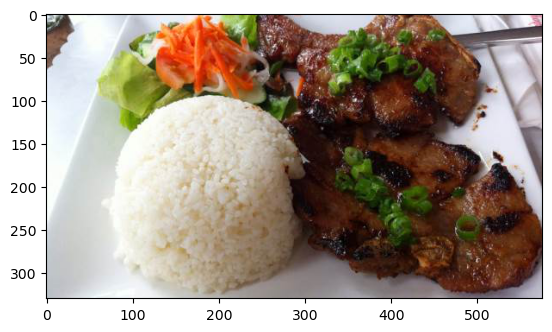

Com tam


In [9]:
from torchvision import transforms
import PIL.Image as Image

url = '/kaggle/input/vn-food/Food/Test/79.jpg'
# Load ảnh
img = Image.open(url)


# Hiển thị ảnh
plt.imshow(img)
plt.show()
# Áp dụng transform

img_transformed = transform(img)



test = loaded_model(img_transformed.to(device))
print(class_name[torch.max(test.data,1)[1].data])

In [10]:
!zip -r abc.zip /kaggle/working/runs

  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/VN_Dishes/ (stored 0%)
  adding: kaggle/working/runs/VN_Dishes/events.out.tfevents.1683042734.ab559544cedb.23.0 (deflated 0%)
  adding: kaggle/working/runs/VN_Dishes/Accuracy and Accuracy_valid_Accuracy_valid/ (stored 0%)
  adding: kaggle/working/runs/VN_Dishes/Accuracy and Accuracy_valid_Accuracy_valid/events.out.tfevents.1683042768.ab559544cedb.23.6 (deflated 72%)
  adding: kaggle/working/runs/VN_Dishes/Loss and Loss_valid_Loss_valid/ (stored 0%)
  adding: kaggle/working/runs/VN_Dishes/Loss and Loss_valid_Loss_valid/events.out.tfevents.1683042768.ab559544cedb.23.4 (deflated 68%)
  adding: kaggle/working/runs/VN_Dishes/Accuracy and Accuracy_valid_Accuracy/ (stored 0%)
  adding: kaggle/working/runs/VN_Dishes/Accuracy and Accuracy_valid_Accuracy/events.out.tfevents.1683042768.ab559544cedb.23.5 (deflated 71%)
  adding: kaggle/working/runs/VN_Dishes/events.out.tfevents.1683042768.ab559544cedb.23.2 (deflated 5%)
  add